# Unit 6. Essential Deep Learning Tips & Tricks

## 6.1 Model Checkpointing and Early Stopping

## Part 3 -- ModelCheckpoint Callbacks

In [1]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, LightningModel

In [2]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [3]:
torch.manual_seed(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)

# NEW: ModelCheckpoint Callback

In [4]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [12]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=20,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my-model/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    To

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 450/450 [00:01<00:00, 237.27it/s, v_num=0, val_loss=0.356, val_acc=0.876, train_acc=0.920]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 450/450 [00:01<00:00, 236.52it/s, v_num=0, val_loss=0.356, val_acc=0.876, train_acc=0.920]


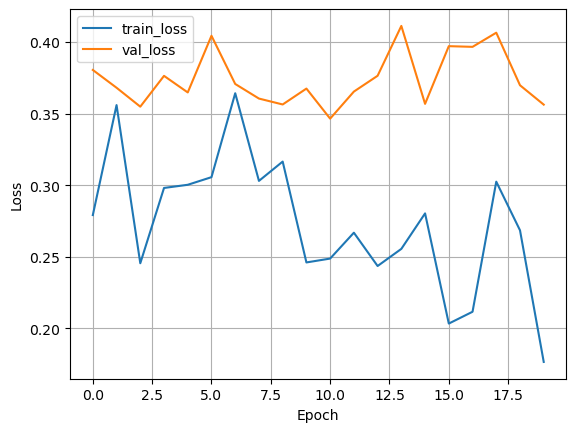

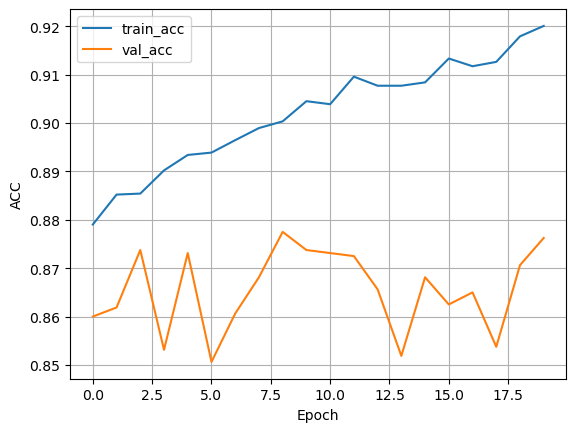

In [13]:
from shared_utilities import plot_csv_logger

plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

# Use the Best Checkpoint

In [14]:
trainer.test(model=lightning_model, datamodule=dm)

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 431.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8744999766349792     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8744999766349792}]

In [15]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=8-step=4050.ckpt
Loaded model weights from the checkpoint at logs/my-model/version_0/checkpoints/epoch=8-step=4050.ckpt


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 439.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8675000071525574     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8675000071525574}]

In [16]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")

Restoring states from the checkpoint path at /Users/alimtleuliyev/Documents/GitHub/dl-course/unit06-dl-tricks/6.1-checkpoints/logs/my-model/version_0/checkpoints/last.ckpt
Loaded model weights from the checkpoint at /Users/alimtleuliyev/Documents/GitHub/dl-course/unit06-dl-tricks/6.1-checkpoints/logs/my-model/version_0/checkpoints/last.ckpt


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 478.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8744999766349792     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8744999766349792}]

In [17]:
path = trainer.checkpoint_callback.best_model_path
print(path)

lightning_model = LightningModel.load_from_checkpoint(
    path, learning_rate=0.1, model=pytorch_model
)
lightning_model.eval();

trainer.test(model=lightning_model, datamodule=dm)

logs/my-model/version_0/checkpoints/epoch=8-step=4050.ckpt
Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 500.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8675000071525574     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8675000071525574}]